In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/SER_TASK')
os.getcwd()

In [ ]:
!pip install folium==0.2.1
!pip install -q transformers

In [ ]:
import pandas as pd
from transformers import BertTokenizer
from tqdm import tqdm

In [ ]:
import torchaudio
from torch.utils.data import DataLoader
import torch
from torch import nn

In [ ]:
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio

"""
Return transformed wav file and labels
"""
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"





class IEMOCAMP_TEXT(Dataset):
    def __init__(self, dataset_path, tokenizer=None):
        self.data = pd.read_csv(dataset_path)
        self.transform = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        y = self.data['labels'][index]
        X = self.data['sentence'][index]
        return {'sentence': X, 'label': y}


if __name__ == "__main__":
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

    usd = IEMOCAMP_TEXT(dataset_path='preprocessed_data/text_train.csv',
                        tokenizer=tokenizer,
                        )
    print(f"There are {len(usd)} samples in the dataset.")
    text, label = usd[0]  # (1, 64, 64)

    

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

There are 5758 samples in the dataset.


In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained("mfuntowicz/bert-base-cased-finetuned-sst2")

train_data = IEMOCAMP_TEXT(dataset_path='preprocessed_data/text_train.csv',
                    tokenizer=tokenizer,
                    )

val_test_data = IEMOCAMP_TEXT(dataset_path='preprocessed_data/text_test.csv',
                    tokenizer=tokenizer,
                    )

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/705 [00:00<?, ?B/s]

In [ ]:
val_data, test_data = torch.utils.data.random_split(
     val_test_data,
    [811, 811],
    generator=torch.Generator().manual_seed(33),
)

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=1000)

In [ ]:
def batch_prep(batch):
    y = batch["label"].to(device)    
    tb = tokenizer(batch['sentence'], truncation=True, padding=True, return_tensors='pt')
    tb = {k : v.to(device) for k, v in tb.items()}
    return tb, y.to(device)

In [ ]:
def evaluate(model, valloader):
    model.eval()
    correct, total = 0, 0    
    with torch.no_grad():
        
        for i, batch in enumerate(tqdm(valloader)):
            tb, y = batch_prep(batch)
            output = model(**tb)

            prediction = torch.argmax(output.data, axis=-1)
            total += prediction.shape[0]
            correct += (prediction == y).sum()

    return (correct/total).item(), prediction, y

In [ ]:
def train_step(epoch, model, trainloader, optim, bert=None, a=1):
    model.train()
    distill_loss = 0
    for batch in trainloader:
        optim.zero_grad()
        new_batch = batch_prep(batch)
        X, y = new_batch
        output = model(**X)   
        loss = loss_fn(output, y) 
        loss.backward()
        optim.step()
    # print(f"Loss {loss.item()}")

## EXP

In [ ]:
class GRU_NET(nn.Module):    
    def __init__(self, vocab_size, n_classes, pad=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 3000, padding_idx=pad)     
        self.gru = nn.GRU(3000, 250, 6, dropout=0.6, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(2 * 250, n_classes)
        
    def forward(self, input_ids, **kwargs):
        embed = self.embedding(input_ids)
        gru, _ = self.gru(embed)
        return self.linear(gru[:,-1])
        

In [ ]:
model = GRU_NET(tokenizer.vocab_size, 5, tokenizer.pad_token_id).to(device)
model

GRU_NET(
  (embedding): Embedding(28996, 3000, padding_idx=0)
  (gru): GRU(3000, 250, num_layers=6, batch_first=True, dropout=0.6, bidirectional=True)
  (linear): Linear(in_features=500, out_features=5, bias=True)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

n_epoch = 50
for epoch in tqdm(range(n_epoch)):
    train_step(epoch, model, train_dataloader, optim=optim)

100%|██████████| 50/50 [10:31<00:00, 12.63s/it]


In [ ]:
torch.save(model.state_dict(), 'baseline/models/text_baseline.pt')
model.load_state_dict(torch.load('baseline/models/text_baseline.pt'))

<All keys matched successfully>

In [ ]:
acc, _, _ = evaluate(model, val_dataloader)
print(f'\nAccuracy on validation set {acc}')

100%|██████████| 13/13 [00:00<00:00, 16.27it/s]


Accuracy on validation set 0.5178791284561157


In [ ]:
torch.cuda.empty_cache()

In [ ]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(y.to('cpu'), prediction.to('cpu'))

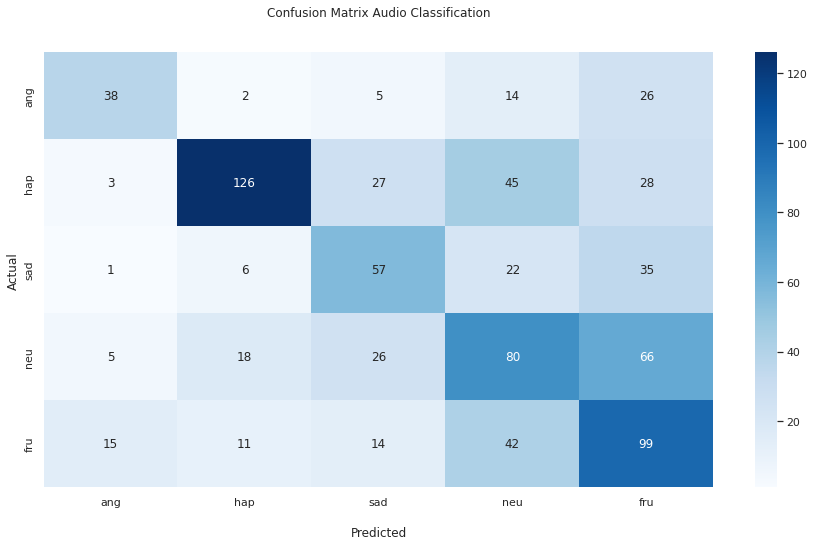

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(15,8)})
# sns.heatmap(table2,annot=True,cmap='Blues', fmt='g')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',  fmt='g')
ax.set_title('Confusion Matrix Audio Classification\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['ang','hap', 'sad', 'neu', 'fru'])
ax.yaxis.set_ticklabels(['ang','hap', 'sad', 'neu', 'fru'])

## Display the visualization of the Confusion Matrix.
plt.savefig('baseline/images/cls_text.png')
plt.show()
